In [6]:
import simplediff
import re

import pandas as pd
import random
import matplotlib.pyplot as plt
import pickle

In [33]:
# filter to have sentence length smaller than max_len
max_len = 100
biased_full_filtered = []
biased_full_filtered_pairs_only = []
biased_full_filtered_idx = []

# change this path to you biased.full file
with open('../cs7650_project_data/neutralizing-bias-data/bias_data/WNC/biased.full') as f:
    for i,line in enumerate(f):
        items = re.sub(' ##','',line).split('\t')
        if len(items[1].split())< 80:
            biased_full_filtered_pairs_only.append((items[1],items[2],items[0]))
            biased_full_filtered.append(line)
            biased_full_filtered_idx.append(i)
print('len(biased_full_filtered)',len(biased_full_filtered))

len(biased_full_filtered) 177220


In [40]:
diff_list = [(simplediff.string_diff(pair[0],pair[1]),pair[2]) for pair in biased_full_filtered_pairs_only]

In [76]:
# filter sentence pairs to have len(del) with 2-6 words
diff_pairs = []
pairs_filterd = []
idx_diff = [] # keep track of indice in pairs full
for i,item in enumerate(diff_list):
    # delete and insert
    diff,wiki_id = item
    if len(diff) == 4 and diff[0][0]=='=' and diff[1][0]=='-' and diff[2][0]=='+' and diff[3][0]=='=':
        deletion = diff[1][1]
        insertion = diff[2][1]
        if len(deletion) > 1 and len(deletion) < 7 and len(insertion) > 1 and len(insertion) < 7:
            diff_pairs.append((' '.join(deletion),' '.join(insertion),wiki_id))
            idx_diff.append(i)
            pairs_filterd.append(biased_full_filtered_pairs_only[i])

print("len(diff_pairs)",len(diff_pairs))

len(diff_pairs) 10421


In [62]:
# Train, eval, text split
n_pairs = len(diff_pairs)
n_eval = int(.7*n_pairs)
n_test = int(.9*n_pairs)
print('pairs len:', n_pairs)
print('n_train:',n_eval)
print('n_eval',n_test-n_eval)
print('n_test',n_pairs-n_test)

pairs len: 10421
n_train: 7294
n_eval 2084
n_test 1043


In [80]:
# create idx for splitting
idx_list = list(range(n_pairs))
random.shuffle(idx_list)

# Prepare file for detection

In [82]:
with open('./biased.full.filtered.train','w') as f:
    text = ''
    for i in idx_list[:n_eval]:
        text+=biased_full_filtered[i]
    f.write(text)

with open('./biased.full.filtered.eval','w') as f:
    text = ''
    for i in idx_list[n_eval:n_test]:
        text+=biased_full_filtered[i]
    f.write(text)

with open('./biased.full.filtered.test','w') as f:
    text = ''
    for i in idx_list[n_test:]:
        text+=biased_full_filtered[i]
    f.write(text)

# Prepare file for translation

In [86]:
with open('./bias-unbias.pair.train','w') as f:
    text = ''
    for i in idx_list[:n_eval]:
        a,b,_ = diff_pairs[i]
        text+=a+'\t'+b+'\n'
    f.write(text)

with open('./bias-unbias.pair.eval','w') as f:
    text = ''
    for i in idx_list[n_eval:n_test]:
        a,b,_ = diff_pairs[i]
        text+=a+'\t'+b+'\n'
    f.write(text)

with open('./bias-unbias.pair.test','w') as f:
    text = ''
    for i in idx_list[n_test:]:
        a,b,_ = diff_pairs[i]
        text+=a+'\t'+b+'\n'
    f.write(text)

# Prepare file for classification

In [89]:
n_choice = len(idx_list)
bias_sent = [pair[0] for pair in pairs_filterd]
neutral_sent = [pair[1] for pair in pairs_filterd]
wiki_id_sent = [pair[2] for pair in pairs_filterd]
print("n_choice", n_choice)

n_choice 10421


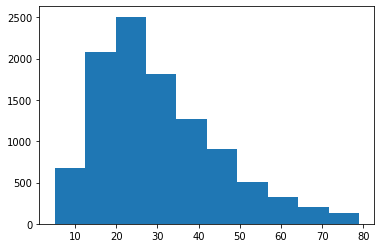

In [90]:
plt.hist(list(map(lambda x: len(x.split()),bias_sent)))
plt.show()

In [109]:
# mix neutral and 
data_pairs_bias = list(zip(wiki_id_sent,bias_sent,[1]*n_choice))
data_pairs_neutral = list(zip(wiki_id_sent,neutral_sent, [0]*n_choice))
data_pairs = []

idx = 0
for i in range(2*n_choice):
    if i%2 is 0:
        data_pairs.append(data_pairs_bias[idx])
    else:
        data_pairs.append(data_pairs_neutral[idx])
        idx+=1
print('len(data_pairs)',len(data_pairs))

len(data_pairs) 20842


In [113]:
df_train = pd.DataFrame(index=range(n_eval),columns=["id","text","biasness",'dummy1','dummy2','dummy3','dummy4','dummy5'])
df_eval = pd.DataFrame(index=range(n_test-n_eval),columns=["id","text","biasness",'dummy1','dummy2','dummy3','dummy4','dummy5'])
df_test = pd.DataFrame(index=range(n_pairs-n_test),columns=["id","text","biasness",'dummy1','dummy2','dummy3','dummy4','dummy5'])

In [116]:
## make sytle consistant with Bert Code required, 6 columns for features
for i in range(n_pairs):
    item = (data_pairs[i][0],data_pairs[i][1],data_pairs[i][2])
    item+=tuple(random.choices([0,1],k=5))
    if i < n_eval:
        df_train.loc[i,] = item
    elif i < n_test:
        df_eval.loc[i-n_eval,] = item
    else:
        df_test.loc[i-n_test,] = item

In [117]:
df_train.to_csv('./train_sample.csv',index=False)
df_eval.to_csv('./eval_sample.csv',index=False)
df_test.to_csv('./test_sample.csv',index=False)